# Spectral Graph Convolutional 

<a href="https://colab.research.google.com/github/joerg84/Graph_Powered_ML_Workshop/blob/master/Spectral_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this nodebook we will explore Spectral Graph Convolution, inspired by https://towardsdatascience.com/spectral-graph-convolution-explained-and-implemented-step-by-step-2e495b57f801.

In [56]:
%%capture
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib
!pip3 install scipy

In [57]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.csgraph import laplacian

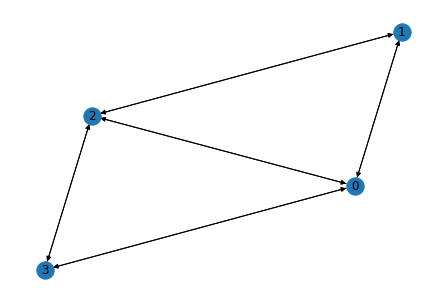

In [58]:
#(undirected) Graph expressed by the adjacency matrix
A = np.matrix([
    [0, 1, 1, 1],
    [1, 0, 1, 0], 
    [1, 1, 0, 1],
    [1, 0, 1, 0]],
    dtype=float
)

# Draw the graph 
G = nx.from_numpy_array(A, create_using=nx.DiGraph())
nx.draw(G, with_labels=True)

Just as a useful trick, that conversions obviously also works the other way around (e.g., when starting from an existing networkx graph).

In [66]:
A1 = nx.to_numpy_array(G)
print(A1)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


While “spectral” may sound complicated, for our purpose it’s enough to understand that it simply means decomposing a signal/audio/image/graph into a combination (usually, a sum) of simple elements (wavelets, graphlets). To have some nice properties of such a decomposition, these simple elements are usually orthogonal, i.e. mutually linearly independent, and therefore form a basis.
When we talk about “spectral” in signal/image processing, we imply the Fourier Transform, which offers us a particular basis (DFT matrix, e.g. scipy.linalg.dft in Python) of elementary sine and cosine waves of different frequencies, so that we can represent our signal/image as a sum of these waves. But when we talk about graphs and graph neural networks (GNNs), “spectral” implies eigen-decomposition of the graph Laplacian L. You can think of the the graph Laplacian L as an adjacency matrix A normalized in a special way, whereas eigen-decomposition is a way to find those elementary orthogonal components that make up our graph.
Intuitively, the graph Laplacian shows in what directions and how smoothly the “energy” will diffuse over a graph if we put some “potential” in node i. A typical use-case of Laplacian in mathematics and physics is to solve how a signal (wave) propagates in a dynamic system. Diffusion is smooth when there is no sudden changes of values between neighbors as in the animation below.


[[ 3. -1. -1. -1.]
 [-1.  2. -1.  0.]
 [-1. -1.  3. -1.]
 [-1.  0. -1.  2.]]


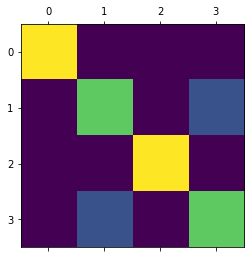

In [70]:
N = A.shape[0] # number of nodes in a graph
deg = np.sum(A, 0) # node degrees
D = np.diagflat(deg)


# Laplace Matrix
L = D - A
print(L)
plt.matshow(L)

[[ 3.         -0.81649658 -1.         -0.81649658]
 [-1.22474487  2.         -1.22474487  0.        ]
 [-1.         -0.81649658  3.         -0.81649658]
 [-1.22474487  0.         -1.22474487  2.        ]]


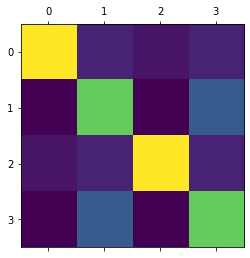

In [68]:
# Normalized Laplacian to avoid exploding values with multiplications 
#(https://math.stackexchange.com/questions/1113467/why-laplacian-matrix-need-normalization-and-how-come-the-sqrt-of-degree-matrix/1113572)
D_sqrt = np.sqrt(D)
L_norm = np.dot(np.dot(np.linalg.inv(D_sqrt) , L), D_sqrt) 
print(L_norm)
plt.matshow(L_norm)

In normal operations we would obviously use a predefined function :-).

[[ 1.         -0.40824829 -0.33333333 -0.40824829]
 [-0.40824829  1.         -0.40824829 -0.        ]
 [-0.33333333 -0.40824829  1.         -0.40824829]
 [-0.40824829 -0.         -0.40824829  1.        ]]


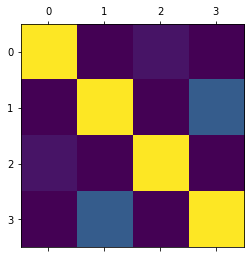

In [72]:
L_norm2 = laplacian(A, normed=True)
print(L_norm2)
plt.matshow(L_norm2)

[[1.         0.99677431 0.98715953 ... 0.01259261 0.01067958 0.00899884]
 [0.99677431 1.         0.99677431 ... 0.01475267 0.01259261 0.01067958]
 [0.98715953 0.99677431 1.         ... 0.01717194 0.01475267 0.01259261]
 ...
 [0.01259261 0.01475267 0.01717194 ... 1.         0.99677431 0.98715953]
 [0.01067958 0.01259261 0.01475267 ... 0.99677431 1.         0.99677431]
 [0.00899884 0.01067958 0.01259261 ... 0.98715953 0.99677431 1.        ]]


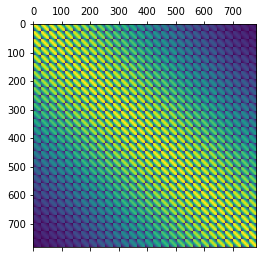

In [54]:
import numpy as np
from scipy.spatial.distance import cdist
img_size = 28  # MNIST image width and height
col, row = np.meshgrid(np.arange(img_size), np.arange(img_size))
coord = np.stack((col, row), axis=2).reshape(-1, 2) / img_size
dist = cdist(coord, coord)  # see figure below on the left
sigma = 0.2 * np.pi  # width of a Gaussian
B = np.exp(- dist ** 2 / sigma ** 2)  # see figure below in the middle

print(B)
plt.matshow(B)